# Installing Packages

In [1]:
%%capture
!pip install iterative-stratification
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install detectron2 -f \https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
import torch


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('display.max_columns', 50)

# Data Preparation

To define custom dataset, we need to create list of dict (dataset_dicts) where each dict contains following:

file_name: file name of the image.

image_id: id of the image, index is used here.

height: height of the image.

width: width of the image.

annotation: This is the ground truth annotation data for object detection, which contains following

bbox: bounding box pixel location with shape (n_boxes, 4)

bbox_mode: BoxMode.XYXY_ABS is used here, meaning that absolute value of (xmin, ymin, xmax, ymax) annotation is used in the bbox.

category_id: class label id for each bounding box, with shape (n_boxes,)

In [ ]:
import pickle
from pathlib import Path
from typing import Optional

import cv2
import numpy as np
import pandas as pd
from detectron2.structures import BoxMode
from tqdm import tqdm

def get_custom_dicts(
    imgdir: Path,
    train_df: pd.DataFrame,
    train_data_type: str = "original",
    use_cache: bool = True,
    debug: bool = True,
    target_image_ids: Optional[np.ndarray] = None,
):
    debug_str = f"_debug{int(debug)}"
    train_data_type_str = f"_{train_data_type}"
    cache_path = Path(".") / f"dataset_dicts_cache{train_data_type_str}{debug_str}.pkl"
    
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        train_meta = pd.read_csv(imgdir / "train_meta.csv")
        if debug:
            train_meta = train_meta.iloc[:200]  # Debug mode: reduce dataset size

        # Load the first image to obtain the resized image dimensions
        first_image_id = train_meta.loc[0, "image_id"]
        first_image_path = str(imgdir / "TRAIN_DETECTRON2" / f"{first_image_id}.png")
        first_image = cv2.imread(first_image_path)
        if first_image is None:
            raise FileNotFoundError(f"First image not found: {first_image_path}")
        resized_height, resized_width, ch = first_image.shape
        print(f"Image shape: {first_image.shape}")

        dataset_dicts = []
        for index, train_meta_row in tqdm(train_meta.iterrows(), total=len(train_meta)):
            record = {}

            image_id, height, width = train_meta_row.values
            filename = str(imgdir / "TRAIN_DETECTRON2" / f"{image_id}.png")
            record["file_name"] = filename
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width

            objs = []
            for index2, row in train_df.query("image_id == @image_id").iterrows():
                
                class_id = row["class_id"]

                # Rescale the bounding box based on the resized image dimensions
                h_ratio = resized_height / height
                w_ratio = resized_width / width
                bbox_resized = [
                    float(row["x_min"]) * w_ratio,
                    float(row["y_min"]) * h_ratio,
                    float(row["x_max"]) * w_ratio,
                    float(row["y_max"]) * h_ratio,
                ]
                obj = {
                    "bbox": bbox_resized,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": class_id,
                }
                objs.append(obj)

            record["annotations"] = objs
            dataset_dicts.append(record)

        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    else:
        print(f"Loading from cache {cache_path}")
        with open(cache_path, mode="rb") as f:
            dataset_dicts = pickle.load(f)
    
    # Correct filtering logic for string-based image IDs
    if target_image_ids is not None:
        target_image_ids_set = set(target_image_ids)
        dataset_dicts = [d for d in dataset_dicts if d["image_id"] in target_image_ids_set]
    
    return dataset_dicts

def get_custom_dicts_test(
    imgdir: Path,
    test_meta: pd.DataFrame,
    use_cache: bool = True,
    debug: bool = True,
    target_image_ids: Optional[np.ndarray] = None,  # Added parameter
):
    debug_str = f"_debug{int(debug)}"
    cache_path = Path(".") / f"dataset_dicts_cache_test{debug_str}.pkl"
    
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        if debug:
            test_meta = test_meta.iloc[:200]  # Reduce data size in debug mode.

        # Load the first image to obtain the resized image dimensions
        first_image_id = test_meta.loc[0, "image_id"]
        first_image_path = str(imgdir / "TEST_DETECTRON2" / f"{first_image_id}.png")
        first_image = cv2.imread(first_image_path)
        if first_image is None:
            raise FileNotFoundError(f"Image not found: {first_image_path}")
        resized_height, resized_width, ch = first_image.shape
        print(f"Image shape: {first_image.shape}")

        dataset_dicts = []
        for index, test_meta_row in tqdm(test_meta.iterrows(), total=len(test_meta)):
            record = {}

            image_id, height, width = test_meta_row.values
            filename = str(imgdir / "TEST_DETECTRON2" / f"{image_id}.png")
            record["file_name"] = filename
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width

            dataset_dicts.append(record)

        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    else:
        print(f"Loading from cache {cache_path}")
        with open(cache_path, mode="rb") as f:
            dataset_dicts = pickle.load(f)
    
    # Correct filtering logic for string-based image IDs
    if target_image_ids is not None:
        target_image_ids_set = set(target_image_ids)
        dataset_dicts = [d for d in dataset_dicts if d["image_id"] in target_image_ids_set]
    
    return dataset_dicts

In [4]:
# --- utils ---
from pathlib import Path
from typing import Any, Union

import yaml


def save_yaml(filepath: Union[str, Path], content: Any, width: int = 120):
    with open(filepath, "w") as f:
        yaml.dump(content, f, width=width)


def load_yaml(filepath: Union[str, Path]) -> Any:
    with open(filepath, "r") as f:
        content = yaml.full_load(f)
    return content


In [ ]:
# --- configs ---
thing_classes = [
    "bina",
    "yol_kesisimi",
    "futbol_sahası",
    "silo"
]
category_name_to_id = {class_name: index for index, class_name in enumerate(thing_classes)}


# Customizing Detectron2 Trainer
## Mapper For Augmentation

In [ ]:
"""
Referenced:
 - https://detectron2.readthedocs.io/en/latest/tutorials/data_loading.html
 - https://www.kaggle.com/dhiiyaur/detectron-2-compare-models-augmentation/#data
"""
import copy
import logging

import detectron2.data.transforms as T
import torch
from detectron2.data import detection_utils as utils


class MyMapper:
    """Mapper which uses `detectron2.data.transforms` augmentations"""

    def __init__(self, cfg, is_train: bool = True):
        aug_kwargs = cfg.aug_kwargs
        aug_list = [
        ]
        if is_train:
            # Making augmentation while training
            aug_list.extend([getattr(T, name)(**kwargs) for name, kwargs in aug_kwargs.items()])
        self.augmentations = T.AugmentationList(aug_list)
        self.is_train = is_train

        mode = "training" if is_train else "inference"
        print(f"[MyDatasetMapper] Augmentations used in {mode}: {self.augmentations}")

    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)  
        image = utils.read_image(dataset_dict["file_name"], format="RGB")  

        aug_input = T.AugInput(image)
        transforms = self.augmentations(aug_input)
        image = aug_input.image

        image_shape = image.shape[:2]  # h, w
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

        annos = [
            utils.transform_instance_annotations(obj, transforms, image_shape)
            for obj in dataset_dict.pop("annotations")
            if obj.get("iscrowd", 0) == 0 
        ]

        instances = utils.annotations_to_instances(annos, image_shape)
        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        
        return dataset_dict


In [ ]:
"""
Referenced:
 - https://detectron2.readthedocs.io/en/latest/tutorials/data_loading.html
 - https://www.kaggle.com/dhiiyaur/detectron-2-compare-models-augmentation/#data
"""
import albumentations as A
import copy
import numpy as np

import torch
from detectron2.data import detection_utils as utils
from detectron2.structures import BoxMode


class AlbumentationsMapper:
    """Mapper which uses albumentations augmentations"""
    def __init__(self, cfg, is_train: bool = True):
        aug_kwargs = cfg.aug_kwargs
        aug_list = []
        
        if is_train:

            aug_list.extend([getattr(A, name)(**kwargs) for name, kwargs in aug_kwargs.items()])
        
        self.transform = A.Compose(
            aug_list, bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category_ids"])
        )
        self.is_train = is_train

        mode = "training" if is_train else "inference"
        print(f"[AlbumentationsMapper] Augmentations used in {mode}: {self.transform}")

    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)  
        image = utils.read_image(dataset_dict["file_name"], format="RGB") 

        prev_anno = dataset_dict["annotations"]
        bboxes = np.array([obj["bbox"] for obj in prev_anno], dtype=np.float32)
        category_id = np.arange(len(dataset_dict["annotations"]))

        transformed = self.transform(image=image, bboxes=bboxes, category_ids=category_id)
        image = transformed["image"]

        annos = []
        for i, j in enumerate(transformed["category_ids"]):
            d = prev_anno[j]
            d["bbox"] = transformed["bboxes"][i]
            annos.append(d)
        dataset_dict.pop("annotations", None)  

        image_shape = image.shape[:2]  
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

        instances = utils.annotations_to_instances(annos, image_shape)

        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        
        return dataset_dict

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning:

A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.



## Repeated Factor Oversampling

In [ ]:
from collections import Counter

def get_class_frequencies(dataset_dict, num_classes):
    class_counts = Counter()
    
    for record in dataset_dict:
        for annotation in record["annotations"]:
            class_id = annotation["category_id"]
            class_counts[class_id] += 1
    
    return [class_counts[i] for i in range(num_classes)]


In [ ]:
from detectron2.data.samplers import RepeatFactorTrainingSampler

def get_repeat_factors(dataset_dicts, class_frequencies, repeat_threshold=0.01):
    # Toplam örnek sayısı
    total_samples = sum(class_frequencies)
    
    repeat_factors = []
    for record in dataset_dicts:
        class_ids = [anno["category_id"] for anno in record["annotations"]]
        max_class_freq = max([class_frequencies[class_id] for class_id in class_ids])
        
        # Calculating repeat factor for rare classes
        repeat_factor = max(1.0, (repeat_threshold * total_samples) / max_class_freq)
        repeat_factors.append(repeat_factor)
    
    return torch.tensor(repeat_factors)

## Evaluator

In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates.
import contextlib
import copy
import io
import itertools
import json
import logging
import numpy as np
import os
import pickle
from collections import OrderedDict
import pycocotools.mask as mask_util
import torch
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tabulate import tabulate

import detectron2.utils.comm as comm
from detectron2.config import CfgNode
from detectron2.data import MetadataCatalog
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.evaluation.fast_eval_api import COCOeval_opt
from detectron2.structures import Boxes, BoxMode, pairwise_iou
from detectron2.utils.file_io import PathManager
from detectron2.utils.logger import create_small_table


class SayzekEvaluator(DatasetEvaluator):
    """
    Evaluate AR for object proposals, AP for instance detection/segmentation, AP
    for keypoint detection outputs using COCO's metrics.
    See http://cocodataset.org/#detection-eval and
    http://cocodataset.org/#keypoints-eval to understand its metrics.

    In addition to COCO, this evaluator is able to support any bounding box detection,
    instance segmentation, or keypoint detection dataset.
    """

    def __init__(
        self,
        dataset_name,
        tasks=None,
        distributed=True,
        output_dir=None,
        *,
        use_fast_impl=True,
        kpt_oks_sigmas=(),
    ):
        """
        Args:
            dataset_name (str): name of the dataset to be evaluated.
                It must have either the following corresponding metadata:

                    "json_file": the path to the COCO format annotation

                Or it must be in detectron2's standard dataset format
                so it can be converted to COCO format automatically.
            tasks (tuple[str]): tasks that can be evaluated under the given
                configuration. A task is one of "bbox", "segm", "keypoints".
                By default, will infer this automatically from predictions.
            distributed (True): if True, will collect results from all ranks and run evaluation
                in the main process.
                Otherwise, will only evaluate the results in the current process.
            output_dir (str): optional, an output directory to dump all
                results predicted on the dataset. The dump contains two files:

                1. "instances_predictions.pth" a file in torch serialization
                   format that contains all the raw original predictions.
                2. "coco_instances_results.json" a json file in COCO's result
                   format.
            use_fast_impl (bool): use a fast but **unofficial** implementation to compute AP.
                Although the results should be very close to the official implementation in COCO
                API, it is still recommended to compute results with the official API for use in
                papers. The faster implementation also uses more RAM.
            kpt_oks_sigmas (list[float]): The sigmas used to calculate keypoint OKS.
                See http://cocodataset.org/#keypoints-eval
                When empty, it will use the defaults in COCO.
                Otherwise it should be the same length as ROI_KEYPOINT_HEAD.NUM_KEYPOINTS.
        """
        self._logger = logging.getLogger(__name__)
        self._distributed = distributed
        self._output_dir = output_dir
        self._use_fast_impl = use_fast_impl

        if tasks is not None and isinstance(tasks, CfgNode):
            kpt_oks_sigmas = (
                tasks.TEST.KEYPOINT_OKS_SIGMAS if not kpt_oks_sigmas else kpt_oks_sigmas
            )
            self._logger.warn(
                "COCO Evaluator instantiated using config, this is deprecated behavior."
                " Please pass in explicit arguments instead."
            )
            self._tasks = None  # Inferring it from predictions should be better
        else:
            self._tasks = tasks

        self._cpu_device = torch.device("cpu")

        self._metadata = MetadataCatalog.get(dataset_name)
        if not hasattr(self._metadata, "json_file"):
            self._logger.info(
                f"'{dataset_name}' is not registered by register_coco_instances."
                " Therefore trying to convert it to COCO format ..."
            )

            cache_path = os.path.join(output_dir, f"{dataset_name}_coco_format.json")
            self._metadata.json_file = cache_path
            convert_to_coco_json(dataset_name, cache_path)

        json_file = PathManager.get_local_path(self._metadata.json_file)
        with contextlib.redirect_stdout(io.StringIO()):
            self._coco_api = COCO(json_file)

        # Test set json files do not contain annotations (evaluation must be
        # performed using the COCO evaluation server).
        self._do_evaluation = "annotations" in self._coco_api.dataset
        if self._do_evaluation:
            self._kpt_oks_sigmas = kpt_oks_sigmas

    def reset(self):
        self._predictions = []

    def process(self, inputs, outputs):
        """
        Args:
            inputs: the inputs to a COCO model (e.g., GeneralizedRCNN).
                It is a list of dict. Each dict corresponds to an image and
                contains keys like "height", "width", "file_name", "image_id".
            outputs: the outputs of a COCO model. It is a list of dicts with key
                "instances" that contains :class:Instances.
        """
        for input, output in zip(inputs, outputs):
            prediction = {"image_id": input["image_id"]}

            if "instances" in output:
                instances = output["instances"].to(self._cpu_device)
                prediction["instances"] = instances_to_coco_json(instances, input["image_id"])
            if "proposals" in output:
                prediction["proposals"] = output["proposals"].to(self._cpu_device)
            if len(prediction) > 1:
                self._predictions.append(prediction)

    def evaluate(self, img_ids=None):
        """
        Args:
            img_ids: a list of image IDs to evaluate on. Default to None for the whole dataset
        """
        if self._distributed:
            comm.synchronize()
            predictions = comm.gather(self._predictions, dst=0)
            predictions = list(itertools.chain(*predictions))

            if not comm.is_main_process():
                return {}
        else:
            predictions = self._predictions

        if len(predictions) == 0:
            self._logger.warning("[SayzekEvaluator] Did not receive valid predictions.")
            return {}

        if self._output_dir:
            PathManager.mkdirs(self._output_dir)
            file_path = os.path.join(self._output_dir, "instances_predictions.pth")
            with PathManager.open(file_path, "wb") as f:
                torch.save(predictions, f)

        self._results = OrderedDict()
        if "proposals" in predictions[0]:
            self._eval_box_proposals(predictions)
        if "instances" in predictions[0]:
            self._eval_predictions(predictions, img_ids=img_ids)
        # Copy so the caller can do whatever with results
        return copy.deepcopy(self._results)

    def _tasks_from_predictions(self, predictions):
        """
        Get COCO API "tasks" (i.e. iou_type) from COCO-format predictions.
        """
        tasks = {"bbox"}
        for pred in predictions:
            if "segmentation" in pred:
                tasks.add("segm")
            if "keypoints" in pred:
                tasks.add("keypoints")
        return sorted(tasks)

    def _eval_predictions(self, predictions, img_ids=None):
        """
        Evaluate predictions. Fill self._results with the metrics of the tasks.
        """
        self._logger.info("Preparing results for COCO format ...")
        coco_results = list(itertools.chain(*[x["instances"] for x in predictions]))
        tasks = self._tasks or self._tasks_from_predictions(coco_results)

        # unmap the category ids for COCO
        if hasattr(self._metadata, "thing_dataset_id_to_contiguous_id"):
            dataset_id_to_contiguous_id = self._metadata.thing_dataset_id_to_contiguous_id
            all_contiguous_ids = list(dataset_id_to_contiguous_id.values())
            num_classes = len(all_contiguous_ids)
            assert min(all_contiguous_ids) == 0 and max(all_contiguous_ids) == num_classes - 1

            reverse_id_mapping = {v: k for k, v in dataset_id_to_contiguous_id.items()}
            for result in coco_results:
                category_id = result["category_id"]
                assert category_id < num_classes, (
                    f"A prediction has class={category_id}, "
                    f"but the dataset only has {num_classes} classes and "
                    f"predicted class id should be in [0, {num_classes - 1}]."
                )
                result["category_id"] = reverse_id_mapping[category_id]

        if self._output_dir:
            file_path = os.path.join(self._output_dir, "coco_instances_results.json")
            self._logger.info("Saving results to {}".format(file_path))
            with PathManager.open(file_path, "w") as f:
                f.write(json.dumps(coco_results))
                f.flush()

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info(
            "Evaluating predictions with {} COCO API...".format(
                "unofficial" if self._use_fast_impl else "official"
            )
        )
        for task in sorted(tasks):
            coco_eval = (
                _evaluate_predictions_on_coco(
                    self._coco_api,
                    coco_results,
                    task,
                    kpt_oks_sigmas=self._kpt_oks_sigmas,
                    use_fast_impl=self._use_fast_impl,
                    img_ids=img_ids,
                )
                if len(coco_results) > 0
                else None 
            )

            res = self._derive_coco_results(
                coco_eval, task, class_names=self._metadata.get("thing_classes")
            )
            self._results[task] = res

    def _eval_box_proposals(self, predictions):
        """
        Evaluate the box proposals in predictions.
        Fill self._results with the metrics for "box_proposals" task.
        """
        if self._output_dir:
            # Saving generated box proposals to file.
            # Predicted box_proposals are in XYXY_ABS mode.
            bbox_mode = BoxMode.XYXY_ABS.value
            ids, boxes, objectness_logits = [], [], []
            for prediction in predictions:
                ids.append(prediction["image_id"])
                boxes.append(prediction["proposals"].proposal_boxes.tensor.numpy())
                objectness_logits.append(prediction["proposals"].objectness_logits.numpy())

            proposal_data = {
                "boxes": boxes,
                "objectness_logits": objectness_logits,
                "ids": ids,
                "bbox_mode": bbox_mode,
            }
            with PathManager.open(os.path.join(self._output_dir, "box_proposals.pkl"), "wb") as f:
                pickle.dump(proposal_data, f)

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info("Evaluating bbox proposals ...")
        res = {}
        areas = {"all": "", "small": "s", "medium": "m", "large": "l"}
        for limit in [100, 1000]:
            for area, suffix in areas.items():
                stats = _evaluate_box_proposals(predictions, self._coco_api, area=area, limit=limit)
                key = "AR{}@{:d}".format(suffix, limit)
                res[key] = float(stats["ar"].item() * 100)
        self._logger.info("Proposal metrics: \n" + create_small_table(res))
        self._results["box_proposals"] = res

    def _derive_coco_results(self, coco_eval, iou_type, class_names=None):
        """
        Derive the desired score numbers from summarized COCOeval.

        Args:
            coco_eval (None or COCOEval): None represents no predictions from model.
            iou_type (str):
            class_names (None or list[str]): if provided, will use it to predict
                per-category AP.

        Returns:
            a dict of {metric name: score}
        """

        metrics = {
            "bbox": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "segm": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "keypoints": ["AP", "AP50", "AP75", "APm", "APl"],
        }[iou_type]

        if coco_eval is None:
            self._logger.warn("No predictions from the model!")
            return {metric: float("nan") for metric in metrics}

        # the standard metrics
        results = {
            metric: float(coco_eval.stats[idx] * 100 if coco_eval.stats[idx] >= 0 else "nan")
            for idx, metric in enumerate(metrics)
        }
        self._logger.info(
            "Evaluation results for {}: \n".format(iou_type) + create_small_table(results)
        )
        if not np.isfinite(sum(results.values())):
            self._logger.info("Some metrics cannot be computed and is shown as NaN.")

        if class_names is None or len(class_names) <= 1:
            return results
        # Compute per-category AP
        # from https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L222-L252 # noqa
        precisions = coco_eval.eval["precision"]
        # precision has dims (iou, recall, cls, area range, max dets)
        assert len(class_names) == precisions.shape[2]

        results_per_category = []
        for idx, name in enumerate(class_names):
            # area range index 0: all area ranges
            # max dets index -1: typically 100 per image
            precision = precisions[:, :, idx, 0, -1]
            precision = precision[precision > -1]
            ap = np.mean(precision) if precision.size else float("nan")
            results_per_category.append(("{}".format(name), float(ap * 100)))

        # tabulate it
        N_COLS = min(6, len(results_per_category) * 2)
        results_flatten = list(itertools.chain(*results_per_category))
        results_2d = itertools.zip_longest(*[results_flatten[i::N_COLS] for i in range(N_COLS)])
        table = tabulate(
            results_2d,
            tablefmt="pipe",
            floatfmt=".3f",
            headers=["category", "AP"] * (N_COLS // 2),
            numalign="left",
        )
        self._logger.info("Per-category {} AP: \n".format(iou_type) + table)

        results.update({"AP-" + name: ap for name, ap in results_per_category})
        return results


def instances_to_coco_json(instances, img_id):
    """
    Dump an "Instances" object to a COCO-format json that's used for evaluation.

    Args:
        instances (Instances):
        img_id (int): the image id

    Returns:
        list[dict]: list of json annotations in COCO format.
    """
    num_instance = len(instances)
    if num_instance == 0:
        return []

    boxes = instances.pred_boxes.tensor.numpy()
    boxes = BoxMode.convert(boxes, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS)
    boxes = boxes.tolist()
    scores = instances.scores.tolist()
    classes = instances.pred_classes.tolist()

    has_mask = instances.has("pred_masks")
    if has_mask:
        # use RLE to encode the masks, because they are too large and takes memory
        # since this evaluator stores outputs of the entire dataset
        rles = [
            mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
            for mask in instances.pred_masks
        ]
        for rle in rles:
            # "counts" is an array encoded by mask_util as a byte-stream. Python3's
            # json writer which always produces strings cannot serialize a bytestream
            # unless you decode it. Thankfully, utf-8 works out (which is also what
            # the pycocotools/_mask.pyx does).
            rle["counts"] = rle["counts"].decode("utf-8")

    has_keypoints = instances.has("pred_keypoints")
    if has_keypoints:
        keypoints = instances.pred_keypoints

    results = []
    for k in range(num_instance):
        result = {
            "image_id": img_id,
            "category_id": classes[k],
            "bbox": boxes[k],
            "score": scores[k],
        }
        if has_mask:
            result["segmentation"] = rles[k]
        if has_keypoints:
            # In COCO annotations,
            # keypoints coordinates are pixel indices.
            # However our predictions are floating point coordinates.
            # Therefore we subtract 0.5 to be consistent with the annotation format.
            # This is the inverse of data loading logic in datasets/coco.py.
            keypoints[k][:, :2] -= 0.5
            result["keypoints"] = keypoints[k].flatten().tolist()
        results.append(result)
    return results


# inspired from Detectron:
# https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L255 # noqa
def _evaluate_box_proposals(dataset_predictions, coco_api, thresholds=None, area="all", limit=None):
    """
    Evaluate detection proposal recall metrics. This function is a much
    faster alternative to the official COCO API recall evaluation code. However,
    it produces slightly different results.
    """
    # Record max overlap value for each gt box
    # Return vector of overlap values
    areas = {
        "all": 0,
        "small": 1,
        "medium": 2,
        "large": 3,
        "96-128": 4,
        "128-256": 5,
        "256-512": 6,
        "512-inf": 7,
    }
    area_ranges = [
        [0 ** 2, 1e5 ** 2],  # all
        [0 ** 2, 32 ** 2],  # small
        [32 ** 2, 96 ** 2],  # medium
        [96 ** 2, 1e5 ** 2],  # large
        [96 ** 2, 128 ** 2],  # 96-128
        [128 ** 2, 256 ** 2],  # 128-256
        [256 ** 2, 512 ** 2],  # 256-512
        [512 ** 2, 1e5 ** 2],
    ]  # 512-inf
    assert area in areas, "Unknown area range: {}".format(area)
    area_range = area_ranges[areas[area]]
    gt_overlaps = []
    num_pos = 0

    for prediction_dict in dataset_predictions:
        predictions = prediction_dict["proposals"]

        # sort predictions in descending order
        # TODO maybe remove this and make it explicit in the documentation
        inds = predictions.objectness_logits.sort(descending=True)[1]
        predictions = predictions[inds]

        ann_ids = coco_api.getAnnIds(imgIds=prediction_dict["image_id"])
        anno = coco_api.loadAnns(ann_ids)
        gt_boxes = [
            BoxMode.convert(obj["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
            for obj in anno
            if obj["iscrowd"] == 0
        ]
        gt_boxes = torch.as_tensor(gt_boxes).reshape(-1, 4)  # guard against no boxes
        gt_boxes = Boxes(gt_boxes)
        gt_areas = torch.as_tensor([obj["area"] for obj in anno if obj["iscrowd"] == 0])

        if len(gt_boxes) == 0 or len(predictions) == 0:
            continue

        valid_gt_inds = (gt_areas >= area_range[0]) & (gt_areas <= area_range[1])
        gt_boxes = gt_boxes[valid_gt_inds]

        num_pos += len(gt_boxes)

        if len(gt_boxes) == 0:
            continue

        if limit is not None and len(predictions) > limit:
            predictions = predictions[:limit]

        overlaps = pairwise_iou(predictions.proposal_boxes, gt_boxes)

        _gt_overlaps = torch.zeros(len(gt_boxes))
        for j in range(min(len(predictions), len(gt_boxes))):
            # find which proposal box maximally covers each gt box
            # and get the iou amount of coverage for each gt box
            max_overlaps, argmax_overlaps = overlaps.max(dim=0)

            # find which gt box is 'best' covered (i.e. 'best' = most iou)
            gt_ovr, gt_ind = max_overlaps.max(dim=0)
            assert gt_ovr >= 0
            # find the proposal box that covers the best covered gt box
            box_ind = argmax_overlaps[gt_ind]
            # record the iou coverage of this gt box
            _gt_overlaps[j] = overlaps[box_ind, gt_ind]
            assert _gt_overlaps[j] == gt_ovr
            # mark the proposal box and the gt box as used
            overlaps[box_ind, :] = -1
            overlaps[:, gt_ind] = -1

        # append recorded iou coverage level
        gt_overlaps.append(_gt_overlaps)
    gt_overlaps = (
        torch.cat(gt_overlaps, dim=0) if len(gt_overlaps) else torch.zeros(0, dtype=torch.float32)
    )
    gt_overlaps, _ = torch.sort(gt_overlaps)

    if thresholds is None:
        step = 0.05
        thresholds = torch.arange(0.5, 0.95 + 1e-5, step, dtype=torch.float32)
    recalls = torch.zeros_like(thresholds)
    # compute recall for each iou threshold
    for i, t in enumerate(thresholds):
        recalls[i] = (gt_overlaps >= t).float().sum() / float(num_pos)
    ar = recalls.mean()
    return {
        "ar": ar,
        "recalls": recalls,
        "thresholds": thresholds,
        "gt_overlaps": gt_overlaps,
        "num_pos": num_pos,
    }


def _evaluate_predictions_on_coco(
    coco_gt, coco_results, iou_type, kpt_oks_sigmas=None, use_fast_impl=True, img_ids=None
):
    """
    Evaluate the coco results using COCOEval API.
    """
    assert len(coco_results) > 0

    if iou_type == "segm":
        coco_results = copy.deepcopy(coco_results)
        # When evaluating mask AP, if the results contain bbox, cocoapi will
        # use the box area as the area of the instance, instead of the mask area.
        # This leads to a different definition of small/medium/large.
        # We remove the bbox field to let mask AP use mask area.
        for c in coco_results:
            c.pop("bbox", None)

    coco_dt = coco_gt.loadRes(coco_results)
    coco_eval = (COCOeval_opt if use_fast_impl else COCOeval)(coco_gt, coco_dt, iou_type)

    if img_ids is not None:
        coco_eval.params.imgIds = img_ids

    if iou_type == "keypoints":
        # Use the COCO default keypoint OKS sigmas unless overrides are specified
        if kpt_oks_sigmas:
            assert hasattr(coco_eval.params, "kpt_oks_sigmas"), "pycocotools is too old!"
            coco_eval.params.kpt_oks_sigmas = np.array(kpt_oks_sigmas)
        # COCOAPI requires every detection and every gt to have keypoints, so
        # we just take the first entry from both
        num_keypoints_dt = len(coco_results[0]["keypoints"]) // 3
        num_keypoints_gt = len(next(iter(coco_gt.anns.values()))["keypoints"]) // 3
        num_keypoints_oks = len(coco_eval.params.kpt_oks_sigmas)
        assert num_keypoints_oks == num_keypoints_dt == num_keypoints_gt, (
            f"[SayzekEvaluator] Prediction contain {num_keypoints_dt} keypoints. "
            f"Ground truth contains {num_keypoints_gt} keypoints. "
            f"The length of cfg.TEST.KEYPOINT_OKS_SIGMAS is {num_keypoints_oks}. "
            "They have to agree with each other. For meaning of OKS, please refer to "
            "http://cocodataset.org/#keypoints-eval."
        )

    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval


## Loss Evaluation Hook

In [11]:
"""
To calculate & record validation loss

Original code from https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
by @apofeniaco
"""
import numpy as np
import logging

from detectron2.engine.hooks import HookBase
from detectron2.utils.logger import log_every_n_seconds
import detectron2.utils.comm as comm
import torch
import time
import datetime


class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader

    def _do_loss_eval(self):
        # Keep the model in training mode to compute losses
        losses = []
        with torch.no_grad():
            for idx, inputs in enumerate(self._data_loader):
                # Compute the loss without gradients
                loss_dict = self._model(inputs)
                # Sum all losses into a single scalar
                total_loss = sum(loss_dict.values()).item()
                losses.append(total_loss)
        # Compute the mean validation loss
        mean_loss = np.mean(losses)
        # Record the validation loss in the trainer's storage
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        return mean_loss

    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            mean_loss = self._do_loss_eval()
            print(f"Validation Loss: {mean_loss}")


## Early Stopping Hook

In [ ]:
class TrainerStopException(Exception):
    """Custom exception to stop training."""
    pass


class EarlyStoppingHook(HookBase):
    def __init__(self, patience: int, eval_period: int, trainer):
        self.patience = patience
        self.eval_period = eval_period
        self.trainer = trainer
        self.best_loss = float('inf')
        self.iter_without_improvement = 0
        self.best_iter = 0  
        self.best_model_weights = None 

    def after_step(self):
        next_iter = self.trainer.iter + 1

        # Only check for early stopping after an evaluation period
        if next_iter % self.eval_period == 0 and next_iter > 0:
            # Get the current validation loss
            validation_loss = self.trainer.storage.history("validation_loss").latest()

            # Check if validation loss has improved
            if validation_loss < self.best_loss:
                self.best_loss = validation_loss
                self.iter_without_improvement = 0
                self.best_iter = self.trainer.iter
                self.best_model_weights = copy.deepcopy(self.trainer.model.state_dict())  # En iyi modeli sakla
                print(f"Validation loss improved to {validation_loss:.4f} at iter {self.best_iter}")
            else:
                self.iter_without_improvement += 1
                print(f"No improvement in validation loss for {self.iter_without_improvement} evaluations.")

            # Check if patience limit is reached
            if self.iter_without_improvement >= self.patience:
                print(f"Early stopping at iteration {self.trainer.iter} due to no improvement in validation loss.")
                
                final_model_path = os.path.join(self.trainer.cfg.OUTPUT_DIR, "best_model.pth")
                torch.save(self.best_model_weights, final_model_path)
                print(f"Best model from iter {self.best_iter} saved to {final_model_path}")

                raise TrainerStopException()



## Setting the Parameters for Trainer Class

In [13]:
import argparse
import dataclasses
import json
import os
import pickle
import random
import sys
from dataclasses import dataclass
from distutils.util import strtobool
from pathlib import Path

import cv2
import detectron2
import numpy as np
import pandas as pd
import torch
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from tqdm import tqdm

setup_logger()

<_Logger detectron2 (DEBUG)>

In [14]:
# --- flags ---
from dataclasses import dataclass, field
from typing import Dict


@dataclass
class Flags:
    # General
    debug: bool = True
    outdir: str = "results/det"

    # Data config
    imgdir_name: str = "sayzek-datathon-data"
    split_mode: str = "all_train"  # all_train or valid20
    seed: int = 111
    train_data_type: str = "original"  # original or wbf
    valid_size: float = 0.16  # Proportion of data to use for validation

    # Training config
    iter: int = 10000
    ims_per_batch: int = 2  # images per batch, this corresponds to "total batch size"
    num_workers: int = 4
    lr_scheduler_name: str = "WarmupMultiStepLR"  # WarmupMultiStepLR (default) or WarmupCosineLR
    base_lr: float = 0.00025
    roi_batch_size_per_image: int = 512
    #eval_period: int = 10000
    aug_kwargs: Dict = field(default_factory=lambda: {})

    def update(self, param_dict: Dict) -> "Flags":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self

In [ ]:
flags_dict = {
    "debug": False,
    "outdir": "results/v1", 
    "imgdir_name": "sayzek-datathon-data",
    "split_mode": "valid16",
    "iter": 2900,
    "roi_batch_size_per_image": 512,
    "ims_per_batch": 2, 
    "lr_scheduler_name": "WarmupCosineLR",
    "base_lr": 0.0020494837715941665,
    "num_workers": 4,
    "valid_size": 0.16,
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5}
    }
}

In [16]:
# args = parse()
print("torch", torch.__version__)
flags = Flags().update(flags_dict)
print("flags", flags)
debug = flags.debug
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)
flags_dict = dataclasses.asdict(flags)
save_yaml(outdir / "flags.yaml", flags_dict)

# --- Read data ---
inputdir = Path("/kaggle/input")
datadir = inputdir / "sayzek-datathon-data"
imgdir = inputdir / flags.imgdir_name

# Read in the data CSV files
train_df = pd.read_csv(datadir / "train_dataset_detectron2.csv")
train = train_df  # alias

torch 2.4.0
flags Flags(debug=False, outdir='results/v1', imgdir_name='sayzek-datathon-data', split_mode='valid16', seed=111, train_data_type='original', valid_size=0.16, iter=2900, ims_per_batch=2, num_workers=4, lr_scheduler_name='WarmupCosineLR', base_lr=0.0020494837715941665, roi_batch_size_per_image=512, aug_kwargs={'HorizontalFlip': {'p': 0.5}, 'ShiftScaleRotate': {'scale_limit': 0.15, 'rotate_limit': 10, 'p': 0.5}, 'RandomBrightnessContrast': {'p': 0.5}})


## Multilabel Stratified Data Splitting Strategy

In [ ]:
train_data_type = flags.train_data_type

split_mode = flags.split_mode
if split_mode == "all_train":
    DatasetCatalog.register(
        "sayzek_train",  
        lambda: get_custom_dicts(
            imgdir, train_df, train_data_type, debug=debug 
        ),
    )
    MetadataCatalog.get("sayzek_train").set(thing_classes=thing_classes)  

elif split_mode == "valid16":
    print("Performing stratified split for valid16...")
    # Read 'train_meta' and apply 'debug' trimming
    train_meta = pd.read_csv(imgdir / "train_meta.csv")
    if debug:
        train_meta = train_meta.iloc[:200]  # Reduce data size in debug mode
    image_ids = train_meta['image_id'].tolist()

    # Filter 'train_df' to only include images in 'train_meta'
    train_df_filtered = train_df[train_df['image_id'].isin(image_ids)]

    # Prepare class labels per image
    class_ids = train_df_filtered[['image_id', 'class_id']]

    # One-hot encode 'class_id'
    encoder = OneHotEncoder(sparse_output=False)
    one_hot_encoded = encoder.fit_transform(class_ids[['class_id']])

    # Get class names
    class_names = ['class_' + str(int(cls)) for cls in encoder.categories_[0]]

    # Create DataFrame and add 'image_id'
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=class_names)
    one_hot_df['image_id'] = class_ids['image_id'].values

    # Group by 'image_id'
    y = one_hot_df.groupby('image_id')[class_names].max().reset_index()
    X = y[['image_id']]

    # Prepare MultilabelStratifiedShuffleSplit using flags.valid_size
    mskf = MultilabelStratifiedShuffleSplit(
        n_splits=1, test_size=flags.valid_size, random_state=flags.seed
    )

    for train_index, valid_index in mskf.split(X, y[class_names]): 
        train_image_ids = X.iloc[train_index]['image_id'].values
        valid_image_ids = X.iloc[valid_index]['image_id'].values

    # Register datasets
    DatasetCatalog.register(
        "sayzek_train",
        lambda: get_custom_dicts(
            imgdir,
            train_df,
            train_data_type,
            debug=debug,
            target_image_ids=train_image_ids,
        ),
    )
    MetadataCatalog.get("sayzek_train").set(thing_classes=thing_classes)

    DatasetCatalog.register(
        "sayzek_valid",
        lambda: get_custom_dicts(
            imgdir,
            train_df,
            train_data_type,
            debug=debug,
            target_image_ids=valid_image_ids,
        ),
    )
    MetadataCatalog.get("sayzek_valid").set(thing_classes=thing_classes)


Performing stratified split for valid16...


## Creating Dataset For Training Process

In [ ]:
import os

from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.data import DatasetCatalog

train_dataset = DatasetCatalog.get("sayzek_train")

class_counts = {i: 0 for i in range(len(thing_classes))}
for record in train_dataset:
    for anno in record["annotations"]:
        class_counts[anno["category_id"]] += 1

class_weights = [1.0 / (class_counts[i] + 1e-6) for i in range(len(thing_classes))]

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        dataset_dicts = DatasetCatalog.get(cfg.DATASETS.TRAIN[0])
        class_frequencies = get_class_frequencies(dataset_dicts, len(thing_classes))
        repeat_factors = get_repeat_factors(dataset_dicts, class_frequencies)
        sampler = RepeatFactorTrainingSampler(repeat_factors)
        
        return build_detection_train_loader(
            cfg, mapper=AlbumentationsMapper(cfg, is_train=True), sampler=sampler
        )

    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(
            cfg, dataset_name, mapper=AlbumentationsMapper(cfg, is_train=False)
        )

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

    def build_hooks(self):
        hooks = super().build_hooks()
        
        # Access cfg using self.cfg
        cfg = self.cfg
        
        # Loss evaluation hook
        loss_eval_hook = LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            self.build_test_loader(cfg, cfg.DATASETS.TEST[0]),
        )
        hooks.insert(-1, loss_eval_hook)
        
        early_stopping_hook = EarlyStoppingHook(patience=5, eval_period=cfg.TEST.EVAL_PERIOD, trainer=self)
        hooks.append(early_stopping_hook)
        
        return hooks

    def train(self):
        try:
            super().train() 
        except TrainerStopException:
            print("Training stopped due to early stopping.")
            
            final_model_path = os.path.join(self.cfg.OUTPUT_DIR, "model_final.pth")
            torch.save(self.model.state_dict(), final_model_path)
            print(f"Model weights saved to {final_model_path}")

Creating data...
Image shape: (512, 512, 3)


100%|██████████| 435/435 [00:01<00:00, 262.17it/s]


In [19]:
dataset_dicts = get_custom_dicts(imgdir, train, debug=debug)

Loading from cache dataset_dicts_cache_original_debug0.pkl


## Training with RetinaNet Architecture

In [ ]:
from detectron2.config.config import CfgNode as CN

cfg = get_cfg()
cfg.aug_kwargs = CN(flags.aug_kwargs)  # pass aug_kwargs to cfg

original_output_dir = cfg.OUTPUT_DIR
cfg.OUTPUT_DIR = str(outdir)
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

config_name = "COCO-Detection/retinanet_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = ("sayzek_train",)
if split_mode == "all_train":
    cfg.DATASETS.TEST = ()
else:
    cfg.DATASETS.TEST = ("sayzek_valid",)

cfg.SOLVER.IMS_PER_BATCH = flags.ims_per_batch
train_dataset = DatasetCatalog.get("sayzek_train")  
num_train_images = len(train_dataset)
cfg.TEST.EVAL_PERIOD = int(num_train_images / cfg.SOLVER.IMS_PER_BATCH) 
cfg.DATALOADER.NUM_WORKERS = flags.num_workers
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
cfg.SOLVER.LR_SCHEDULER_NAME = flags.lr_scheduler_name
cfg.SOLVER.BASE_LR = flags.base_lr  
cfg.SOLVER.MAX_ITER = flags.iter
cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = flags.roi_batch_size_per_image
cfg.MODEL.RETINANET.NUM_CLASSES = len(thing_classes)
cfg.MODEL.RETINANET.FOCAL_LOSS_GAMMA = 2.1991655897499314 
cfg.MODEL.RETINANET.FOCAL_LOSS_ALPHA = 0.1546578114111799  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


cfg.OUTPUT_DIR ./output -> results/v1
Loading from cache dataset_dicts_cache_original_debug0.pkl


In [21]:
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/15 11:42:44 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py:191: UserWarning:

Got processor for bboxes, but no transform to process it.

model_final_5bd44e.pkl: 152MB [00:00, 242MB/s]                            


[10/15 11:42:45 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)



[10/15 11:42:52 d2.utils.events]:  eta: 0:07:03  iter: 19  total_loss: 1.828  loss_cls: 0.9255  loss_box_reg: 0.9154    time: 0.2143  last_time: 0.1385  data_time: 0.0199  last_data_time: 0.0076   lr: 3.0601e-05  max_mem: 1792M
[10/15 11:43:07 d2.utils.events]:  eta: 0:07:12  iter: 39  total_loss: 1.106  loss_cls: 0.602  loss_box_reg: 0.4711    time: 0.1897  last_time: 0.1351  data_time: 0.0102  last_data_time: 0.0063   lr: 6.0654e-05  max_mem: 1793M
[10/15 11:43:10 d2.utils.events]:  eta: 0:07:13  iter: 59  total_loss: 0.9759  loss_cls: 0.5947  loss_box_reg: 0.4011    time: 0.1783  last_time: 0.1632  data_time: 0.0094  last_data_time: 0.0154   lr: 9.0708e-05  max_mem: 1794M
[10/15 11:43:13 d2.utils.events]:  eta: 0:07:06  iter: 79  total_loss: 0.8802  loss_cls: 0.4926  loss_box_reg: 0.4187    time: 0.1711  last_time: 0.1765  data_time: 0.0096  last_data_time: 0.0146   lr: 0.00012076  max_mem: 1794M
[10/15 11:43:16 d2.utils.events]:  eta: 0:07:00  iter: 99  total_loss: 0.8448  loss_cls

/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py:191: UserWarning:

Got processor for bboxes, but no transform to process it.



[10/15 11:43:29 d2.data.datasets.coco]: Conversion finished, #images: 71, #annotations: 1063
[10/15 11:43:29 d2.data.datasets.coco]: Caching COCO format annotations at 'results/v1/inference/sayzek_valid_coco_format.json' ...
[10/15 11:43:29 d2.evaluation.evaluator]: Start inference on 71 batches


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:43:29 d2.evaluation.evaluator]: Inference done 11/71. Dataloading: 0.0020 s/iter. Inference: 0.0346 s/iter. Eval: 0.0004 s/iter. Total: 0.0370 s/iter. ETA=0:00:02


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:43:32 d2.evaluation.evaluator]: Total inference time: 0:00:02.522650 (0.038222 s / iter per device, on 1 devices)
[10/15 11:43:32 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.034055 s / iter per device, on 1 devices)
[10/15 11:43:32 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/15 11:43:32 d2.evaluation.coco_evaluation]: Saving results to results/v1/inference/coco_instances_results.json
[10/15 11:43:32 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[10/15 11:43:32 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[10/15 11:43:32 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.09 seconds.
[10/15 11:43:32 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[10/15 11:43:32 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Pre

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Validation Loss: 0.6009594453892237
Validation loss improved to 0.6010 at iter 181
[10/15 11:43:38 d2.utils.events]:  eta: 0:06:33  iter: 199  total_loss: 0.7749  loss_cls: 0.3225  loss_box_reg: 0.4524  validation_loss: 0.601    time: 0.1567  last_time: 0.1636  data_time: 0.0118  last_data_time: 0.0089   lr: 0.00030108  max_mem: 1937M
[10/15 11:43:41 d2.utils.events]:  eta: 0:06:31  iter: 219  total_loss: 0.6627  loss_cls: 0.287  loss_box_reg: 0.3847  validation_loss: 0.601    time: 0.1571  last_time: 0.1256  data_time: 0.0100  last_data_time: 0.0069   lr: 0.00033114  max_mem: 1937M
[10/15 11:43:44 d2.utils.events]:  eta: 0:06:27  iter: 239  total_loss: 0.6219  loss_cls: 0.2642  loss_box_reg: 0.3764  validation_loss: 0.601    time: 0.1566  last_time: 0.1762  data_time: 0.0131  last_data_time: 0.0187   lr: 0.00036119  max_mem: 1937M
[10/15 11:43:47 d2.utils.events]:  eta: 0:06:23  iter: 259  total_loss: 0.5495  loss_cls: 0.2417  loss_box_reg: 0.3106  validation_loss: 0.601    time: 0.15

/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py:191: UserWarning:

Got processor for bboxes, but no transform to process it.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:44:04 d2.evaluation.evaluator]: Inference done 11/71. Dataloading: 0.0021 s/iter. Inference: 0.0326 s/iter. Eval: 0.0004 s/iter. Total: 0.0351 s/iter. ETA=0:00:02


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:44:06 d2.evaluation.evaluator]: Total inference time: 0:00:02.432870 (0.036862 s / iter per device, on 1 devices)
[10/15 11:44:06 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.032789 s / iter per device, on 1 devices)
[10/15 11:44:06 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/15 11:44:06 d2.evaluation.coco_evaluation]: Saving results to results/v1/inference/coco_instances_results.json
[10/15 11:44:06 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[10/15 11:44:06 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[10/15 11:44:06 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[10/15 11:44:06 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[10/15 11:44:06 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Pre

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Validation Loss: 0.5154332904748513
Validation loss improved to 0.5154 at iter 363
[10/15 11:44:11 d2.utils.events]:  eta: 0:06:07  iter: 379  total_loss: 0.488  loss_cls: 0.1971  loss_box_reg: 0.2922  validation_loss: 0.5154    time: 0.1554  last_time: 0.1464  data_time: 0.0142  last_data_time: 0.0173   lr: 0.00057157  max_mem: 1938M
[10/15 11:44:15 d2.utils.events]:  eta: 0:06:04  iter: 399  total_loss: 0.4707  loss_cls: 0.1914  loss_box_reg: 0.2885  validation_loss: 0.5154    time: 0.1554  last_time: 0.1486  data_time: 0.0098  last_data_time: 0.0246   lr: 0.00060162  max_mem: 1938M
[10/15 11:44:17 d2.utils.events]:  eta: 0:06:01  iter: 419  total_loss: 0.5719  loss_cls: 0.2248  loss_box_reg: 0.3492  validation_loss: 0.5154    time: 0.1550  last_time: 0.1548  data_time: 0.0099  last_data_time: 0.0070   lr: 0.00063168  max_mem: 1938M
[10/15 11:44:20 d2.utils.events]:  eta: 0:05:58  iter: 439  total_loss: 0.515  loss_cls: 0.1926  loss_box_reg: 0.3103  validation_loss: 0.5154    time: 0

/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py:191: UserWarning:

Got processor for bboxes, but no transform to process it.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:44:39 d2.evaluation.evaluator]: Inference done 11/71. Dataloading: 0.0019 s/iter. Inference: 0.0344 s/iter. Eval: 0.0005 s/iter. Total: 0.0367 s/iter. ETA=0:00:02


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:44:41 d2.evaluation.evaluator]: Total inference time: 0:00:02.538503 (0.038462 s / iter per device, on 1 devices)
[10/15 11:44:41 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.033678 s / iter per device, on 1 devices)
[10/15 11:44:41 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/15 11:44:41 d2.evaluation.coco_evaluation]: Saving results to results/v1/inference/coco_instances_results.json
[10/15 11:44:41 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[10/15 11:44:41 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[10/15 11:44:41 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[10/15 11:44:41 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[10/15 11:44:41 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Pre

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Validation Loss: 0.4565783763225649
Validation loss improved to 0.4566 at iter 545
[10/15 11:44:46 d2.utils.events]:  eta: 0:05:41  iter: 559  total_loss: 0.5875  loss_cls: 0.2101  loss_box_reg: 0.3659  validation_loss: 0.4566    time: 0.1537  last_time: 0.1250  data_time: 0.0097  last_data_time: 0.0054   lr: 0.00084205  max_mem: 1938M
[10/15 11:44:49 d2.utils.events]:  eta: 0:05:38  iter: 579  total_loss: 0.4683  loss_cls: 0.1792  loss_box_reg: 0.2909  validation_loss: 0.4566    time: 0.1537  last_time: 0.1306  data_time: 0.0101  last_data_time: 0.0060   lr: 0.00087211  max_mem: 1938M
[10/15 11:44:52 d2.utils.events]:  eta: 0:05:35  iter: 599  total_loss: 0.5084  loss_cls: 0.1787  loss_box_reg: 0.3271  validation_loss: 0.4566    time: 0.1534  last_time: 0.1403  data_time: 0.0103  last_data_time: 0.0066   lr: 0.00090216  max_mem: 1938M
[10/15 11:44:55 d2.utils.events]:  eta: 0:05:32  iter: 619  total_loss: 0.4192  loss_cls: 0.1565  loss_box_reg: 0.2531  validation_loss: 0.4566    time:

/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py:191: UserWarning:

Got processor for bboxes, but no transform to process it.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:45:12 d2.evaluation.evaluator]: Inference done 11/71. Dataloading: 0.0021 s/iter. Inference: 0.0334 s/iter. Eval: 0.0005 s/iter. Total: 0.0359 s/iter. ETA=0:00:02


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:45:15 d2.evaluation.evaluator]: Total inference time: 0:00:02.654272 (0.040216 s / iter per device, on 1 devices)
[10/15 11:45:15 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.035065 s / iter per device, on 1 devices)
[10/15 11:45:15 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/15 11:45:15 d2.evaluation.coco_evaluation]: Saving results to results/v1/inference/coco_instances_results.json
[10/15 11:45:15 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[10/15 11:45:15 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[10/15 11:45:15 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[10/15 11:45:15 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[10/15 11:45:15 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Pre

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Validation Loss: 0.44558749988045493
Validation loss improved to 0.4456 at iter 727
[10/15 11:45:19 d2.utils.events]:  eta: 0:05:14  iter: 739  total_loss: 0.54  loss_cls: 0.2042  loss_box_reg: 0.3316  validation_loss: 0.4456    time: 0.1531  last_time: 0.1492  data_time: 0.0129  last_data_time: 0.0281   lr: 0.0011125  max_mem: 1938M
[10/15 11:45:22 d2.utils.events]:  eta: 0:05:12  iter: 759  total_loss: 0.5367  loss_cls: 0.2159  loss_box_reg: 0.3189  validation_loss: 0.4456    time: 0.1531  last_time: 0.1521  data_time: 0.0090  last_data_time: 0.0089   lr: 0.0011426  max_mem: 1938M
[10/15 11:45:26 d2.utils.events]:  eta: 0:05:09  iter: 779  total_loss: 0.469  loss_cls: 0.1731  loss_box_reg: 0.2896  validation_loss: 0.4456    time: 0.1531  last_time: 0.1303  data_time: 0.0102  last_data_time: 0.0097   lr: 0.0011726  max_mem: 1938M
[10/15 11:45:29 d2.utils.events]:  eta: 0:05:06  iter: 799  total_loss: 0.4888  loss_cls: 0.1748  loss_box_reg: 0.3105  validation_loss: 0.4456    time: 0.15

/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py:191: UserWarning:

Got processor for bboxes, but no transform to process it.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:45:46 d2.evaluation.evaluator]: Inference done 11/71. Dataloading: 0.0026 s/iter. Inference: 0.0365 s/iter. Eval: 0.0006 s/iter. Total: 0.0397 s/iter. ETA=0:00:02


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:45:49 d2.evaluation.evaluator]: Total inference time: 0:00:02.605267 (0.039474 s / iter per device, on 1 devices)
[10/15 11:45:49 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.034532 s / iter per device, on 1 devices)
[10/15 11:45:49 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/15 11:45:49 d2.evaluation.coco_evaluation]: Saving results to results/v1/inference/coco_instances_results.json
[10/15 11:45:49 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[10/15 11:45:49 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[10/15 11:45:49 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[10/15 11:45:49 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[10/15 11:45:49 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Pre

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Validation Loss: 0.42633868549281445
Validation loss improved to 0.4263 at iter 909
[10/15 11:45:53 d2.utils.events]:  eta: 0:04:48  iter: 919  total_loss: 0.4683  loss_cls: 0.1701  loss_box_reg: 0.302  validation_loss: 0.4263    time: 0.1527  last_time: 0.1406  data_time: 0.0107  last_data_time: 0.0066   lr: 0.001383  max_mem: 1939M
[10/15 11:45:56 d2.utils.events]:  eta: 0:04:45  iter: 939  total_loss: 0.4716  loss_cls: 0.1542  loss_box_reg: 0.3227  validation_loss: 0.4263    time: 0.1527  last_time: 0.1317  data_time: 0.0113  last_data_time: 0.0092   lr: 0.0014131  max_mem: 1939M
[10/15 11:45:59 d2.utils.events]:  eta: 0:04:42  iter: 959  total_loss: 0.3836  loss_cls: 0.1473  loss_box_reg: 0.2391  validation_loss: 0.4263    time: 0.1524  last_time: 0.1327  data_time: 0.0090  last_data_time: 0.0095   lr: 0.0014431  max_mem: 1939M
[10/15 11:46:02 d2.utils.events]:  eta: 0:04:39  iter: 979  total_loss: 0.4768  loss_cls: 0.1609  loss_box_reg: 0.3087  validation_loss: 0.4263    time: 0.1

/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py:191: UserWarning:

Got processor for bboxes, but no transform to process it.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:46:20 d2.evaluation.evaluator]: Inference done 11/71. Dataloading: 0.0017 s/iter. Inference: 0.0343 s/iter. Eval: 0.0005 s/iter. Total: 0.0364 s/iter. ETA=0:00:02


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:46:22 d2.evaluation.evaluator]: Total inference time: 0:00:02.517238 (0.038140 s / iter per device, on 1 devices)
[10/15 11:46:22 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.033947 s / iter per device, on 1 devices)
[10/15 11:46:22 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/15 11:46:22 d2.evaluation.coco_evaluation]: Saving results to results/v1/inference/coco_instances_results.json
[10/15 11:46:22 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[10/15 11:46:22 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[10/15 11:46:22 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[10/15 11:46:22 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[10/15 11:46:22 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Pre

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Validation Loss: 0.40759501044808977
Validation loss improved to 0.4076 at iter 1091
[10/15 11:46:26 d2.utils.events]:  eta: 0:04:21  iter: 1099  total_loss: 0.3109  loss_cls: 0.1173  loss_box_reg: 0.1952  validation_loss: 0.4076    time: 0.1525  last_time: 0.1637  data_time: 0.0123  last_data_time: 0.0078   lr: 0.0014051  max_mem: 1940M
[10/15 11:46:29 d2.utils.events]:  eta: 0:04:18  iter: 1119  total_loss: 0.536  loss_cls: 0.1842  loss_box_reg: 0.3401  validation_loss: 0.4076    time: 0.1525  last_time: 0.1267  data_time: 0.0114  last_data_time: 0.0070   lr: 0.0013844  max_mem: 1940M
[10/15 11:46:32 d2.utils.events]:  eta: 0:04:15  iter: 1139  total_loss: 0.3701  loss_cls: 0.139  loss_box_reg: 0.237  validation_loss: 0.4076    time: 0.1523  last_time: 0.1249  data_time: 0.0105  last_data_time: 0.0065   lr: 0.0013635  max_mem: 1940M
[10/15 11:46:35 d2.utils.events]:  eta: 0:04:13  iter: 1159  total_loss: 0.4268  loss_cls: 0.1459  loss_box_reg: 0.2815  validation_loss: 0.4076    time:

/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py:191: UserWarning:

Got processor for bboxes, but no transform to process it.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:46:53 d2.evaluation.evaluator]: Inference done 11/71. Dataloading: 0.0021 s/iter. Inference: 0.0328 s/iter. Eval: 0.0004 s/iter. Total: 0.0354 s/iter. ETA=0:00:02


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:46:55 d2.evaluation.evaluator]: Total inference time: 0:00:02.449451 (0.037113 s / iter per device, on 1 devices)
[10/15 11:46:55 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.032544 s / iter per device, on 1 devices)
[10/15 11:46:55 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/15 11:46:55 d2.evaluation.coco_evaluation]: Saving results to results/v1/inference/coco_instances_results.json
[10/15 11:46:55 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[10/15 11:46:55 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[10/15 11:46:56 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[10/15 11:46:56 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[10/15 11:46:56 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Pre

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Validation Loss: 0.3881525206838695
Validation loss improved to 0.3882 at iter 1273
[10/15 11:46:59 d2.utils.events]:  eta: 0:03:55  iter: 1279  total_loss: 0.4711  loss_cls: 0.1621  loss_box_reg: 0.3154  validation_loss: 0.3882    time: 0.1521  last_time: 0.1528  data_time: 0.0092  last_data_time: 0.0068   lr: 0.0012135  max_mem: 1940M
[10/15 11:47:02 d2.utils.events]:  eta: 0:03:52  iter: 1299  total_loss: 0.3436  loss_cls: 0.1115  loss_box_reg: 0.2445  validation_loss: 0.3882    time: 0.1520  last_time: 0.1546  data_time: 0.0105  last_data_time: 0.0206   lr: 0.0011916  max_mem: 1940M
[10/15 11:47:05 d2.utils.events]:  eta: 0:03:49  iter: 1319  total_loss: 0.4479  loss_cls: 0.17  loss_box_reg: 0.2687  validation_loss: 0.3882    time: 0.1520  last_time: 0.1453  data_time: 0.0149  last_data_time: 0.0075   lr: 0.0011697  max_mem: 1940M
[10/15 11:47:08 d2.utils.events]:  eta: 0:03:46  iter: 1339  total_loss: 0.3768  loss_cls: 0.1252  loss_box_reg: 0.2428  validation_loss: 0.3882    time:

/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py:191: UserWarning:

Got processor for bboxes, but no transform to process it.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:47:26 d2.evaluation.evaluator]: Inference done 11/71. Dataloading: 0.0022 s/iter. Inference: 0.0338 s/iter. Eval: 0.0004 s/iter. Total: 0.0365 s/iter. ETA=0:00:02


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:47:29 d2.evaluation.evaluator]: Total inference time: 0:00:02.507600 (0.037994 s / iter per device, on 1 devices)
[10/15 11:47:29 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.033551 s / iter per device, on 1 devices)
[10/15 11:47:29 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/15 11:47:29 d2.evaluation.coco_evaluation]: Saving results to results/v1/inference/coco_instances_results.json
[10/15 11:47:29 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[10/15 11:47:29 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[10/15 11:47:29 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[10/15 11:47:29 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[10/15 11:47:29 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Pre

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Validation Loss: 0.41249315099607053
No improvement in validation loss for 1 evaluations.
[10/15 11:47:32 d2.utils.events]:  eta: 0:03:28  iter: 1459  total_loss: 0.3824  loss_cls: 0.1332  loss_box_reg: 0.243  validation_loss: 0.4125    time: 0.1518  last_time: 0.1469  data_time: 0.0100  last_data_time: 0.0183   lr: 0.0010148  max_mem: 1940M
[10/15 11:47:35 d2.utils.events]:  eta: 0:03:25  iter: 1479  total_loss: 0.4468  loss_cls: 0.1562  loss_box_reg: 0.29  validation_loss: 0.4125    time: 0.1518  last_time: 0.1452  data_time: 0.0109  last_data_time: 0.0106   lr: 0.00099255  max_mem: 1940M
[10/15 11:47:38 d2.utils.events]:  eta: 0:03:23  iter: 1499  total_loss: 0.3182  loss_cls: 0.1052  loss_box_reg: 0.2145  validation_loss: 0.4125    time: 0.1518  last_time: 0.1638  data_time: 0.0120  last_data_time: 0.0234   lr: 0.00097037  max_mem: 1940M
[10/15 11:47:41 d2.utils.events]:  eta: 0:03:20  iter: 1519  total_loss: 0.3189  loss_cls: 0.1197  loss_box_reg: 0.1952  validation_loss: 0.4125  

/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py:191: UserWarning:

Got processor for bboxes, but no transform to process it.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:48:00 d2.evaluation.evaluator]: Inference done 11/71. Dataloading: 0.0025 s/iter. Inference: 0.0330 s/iter. Eval: 0.0005 s/iter. Total: 0.0360 s/iter. ETA=0:00:02


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:48:03 d2.evaluation.evaluator]: Total inference time: 0:00:03.087841 (0.046785 s / iter per device, on 1 devices)
[10/15 11:48:03 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.042279 s / iter per device, on 1 devices)
[10/15 11:48:03 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/15 11:48:03 d2.evaluation.coco_evaluation]: Saving results to results/v1/inference/coco_instances_results.json
[10/15 11:48:03 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[10/15 11:48:03 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[10/15 11:48:03 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[10/15 11:48:03 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[10/15 11:48:03 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Pre

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Validation Loss: 0.3924866222684652
No improvement in validation loss for 2 evaluations.
[10/15 11:48:06 d2.utils.events]:  eta: 0:03:02  iter: 1639  total_loss: 0.3244  loss_cls: 0.1102  loss_box_reg: 0.223  validation_loss: 0.3925    time: 0.1518  last_time: 0.1610  data_time: 0.0129  last_data_time: 0.0237   lr: 0.00081639  max_mem: 1940M
[10/15 11:48:09 d2.utils.events]:  eta: 0:03:00  iter: 1659  total_loss: 0.377  loss_cls: 0.1288  loss_box_reg: 0.2501  validation_loss: 0.3925    time: 0.1518  last_time: 0.1559  data_time: 0.0141  last_data_time: 0.0222   lr: 0.00079471  max_mem: 1940M
[10/15 11:48:12 d2.utils.events]:  eta: 0:02:57  iter: 1679  total_loss: 0.3283  loss_cls: 0.1002  loss_box_reg: 0.2281  validation_loss: 0.3925    time: 0.1519  last_time: 0.1274  data_time: 0.0117  last_data_time: 0.0104   lr: 0.00077313  max_mem: 1940M
[10/15 11:48:15 d2.utils.events]:  eta: 0:02:54  iter: 1699  total_loss: 0.3412  loss_cls: 0.122  loss_box_reg: 0.2064  validation_loss: 0.3925  

/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py:191: UserWarning:

Got processor for bboxes, but no transform to process it.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:48:35 d2.evaluation.evaluator]: Inference done 11/71. Dataloading: 0.0022 s/iter. Inference: 0.0330 s/iter. Eval: 0.0005 s/iter. Total: 0.0356 s/iter. ETA=0:00:02


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:48:37 d2.evaluation.evaluator]: Total inference time: 0:00:02.529799 (0.038330 s / iter per device, on 1 devices)
[10/15 11:48:37 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.033747 s / iter per device, on 1 devices)
[10/15 11:48:37 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/15 11:48:37 d2.evaluation.coco_evaluation]: Saving results to results/v1/inference/coco_instances_results.json
[10/15 11:48:37 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[10/15 11:48:37 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[10/15 11:48:37 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[10/15 11:48:37 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[10/15 11:48:37 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Pre

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Validation Loss: 0.4065186273778828
[10/15 11:48:40 d2.utils.events]:  eta: 0:02:37  iter: 1819  total_loss: 0.2912  loss_cls: 0.1021  loss_box_reg: 0.1973  validation_loss: 0.4065    time: 0.1521  last_time: 0.1371  data_time: 0.0096  last_data_time: 0.0101   lr: 0.00062593  max_mem: 1940M
No improvement in validation loss for 3 evaluations.
[10/15 11:48:43 d2.utils.events]:  eta: 0:02:34  iter: 1839  total_loss: 0.3456  loss_cls: 0.1178  loss_box_reg: 0.2288  validation_loss: 0.4065    time: 0.1520  last_time: 0.1303  data_time: 0.0089  last_data_time: 0.0124   lr: 0.00060558  max_mem: 1940M
[10/15 11:48:46 d2.utils.events]:  eta: 0:02:31  iter: 1859  total_loss: 0.4203  loss_cls: 0.1379  loss_box_reg: 0.2687  validation_loss: 0.4065    time: 0.1521  last_time: 0.1732  data_time: 0.0107  last_data_time: 0.0096   lr: 0.00058542  max_mem: 1940M
[10/15 11:48:49 d2.utils.events]:  eta: 0:02:28  iter: 1879  total_loss: 0.3777  loss_cls: 0.1205  loss_box_reg: 0.2519  validation_loss: 0.406

/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py:191: UserWarning:

Got processor for bboxes, but no transform to process it.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:49:08 d2.evaluation.evaluator]: Inference done 11/71. Dataloading: 0.0017 s/iter. Inference: 0.0332 s/iter. Eval: 0.0005 s/iter. Total: 0.0354 s/iter. ETA=0:00:02


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:49:10 d2.evaluation.evaluator]: Total inference time: 0:00:02.404227 (0.036428 s / iter per device, on 1 devices)
[10/15 11:49:10 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.032251 s / iter per device, on 1 devices)
[10/15 11:49:10 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/15 11:49:10 d2.evaluation.coco_evaluation]: Saving results to results/v1/inference/coco_instances_results.json
[10/15 11:49:10 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[10/15 11:49:10 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[10/15 11:49:10 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[10/15 11:49:10 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[10/15 11:49:10 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Pre

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Validation Loss: 0.3822966447808373
Validation loss improved to 0.3823 at iter 2001
[10/15 11:49:16 d2.utils.events]:  eta: 0:02:08  iter: 2019  total_loss: 0.3982  loss_cls: 0.1222  loss_box_reg: 0.2729  validation_loss: 0.3823    time: 0.1518  last_time: 0.1463  data_time: 0.0106  last_data_time: 0.0150   lr: 0.00043234  max_mem: 1940M
[10/15 11:49:18 d2.utils.events]:  eta: 0:02:04  iter: 2039  total_loss: 0.3179  loss_cls: 0.0921  loss_box_reg: 0.2019  validation_loss: 0.3823    time: 0.1517  last_time: 0.1303  data_time: 0.0102  last_data_time: 0.0085   lr: 0.00041436  max_mem: 1940M
[10/15 11:49:21 d2.utils.events]:  eta: 0:02:02  iter: 2059  total_loss: 0.3424  loss_cls: 0.1181  loss_box_reg: 0.2285  validation_loss: 0.3823    time: 0.1516  last_time: 0.1402  data_time: 0.0088  last_data_time: 0.0062   lr: 0.00039667  max_mem: 1940M
[10/15 11:49:24 d2.utils.events]:  eta: 0:01:59  iter: 2079  total_loss: 0.3168  loss_cls: 0.1099  loss_box_reg: 0.2093  validation_loss: 0.3823    

/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py:191: UserWarning:

Got processor for bboxes, but no transform to process it.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:49:41 d2.evaluation.evaluator]: Inference done 11/71. Dataloading: 0.0017 s/iter. Inference: 0.0335 s/iter. Eval: 0.0005 s/iter. Total: 0.0357 s/iter. ETA=0:00:02


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:49:43 d2.evaluation.evaluator]: Total inference time: 0:00:02.432091 (0.036850 s / iter per device, on 1 devices)
[10/15 11:49:43 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.032584 s / iter per device, on 1 devices)
[10/15 11:49:43 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/15 11:49:43 d2.evaluation.coco_evaluation]: Saving results to results/v1/inference/coco_instances_results.json
[10/15 11:49:43 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[10/15 11:49:43 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[10/15 11:49:43 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[10/15 11:49:43 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[10/15 11:49:43 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Pre

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Validation Loss: 0.3910457128790063
No improvement in validation loss for 1 evaluations.
[10/15 11:49:48 d2.utils.events]:  eta: 0:01:41  iter: 2199  total_loss: 0.3238  loss_cls: 0.1116  loss_box_reg: 0.2092  validation_loss: 0.391    time: 0.1516  last_time: 0.1251  data_time: 0.0096  last_data_time: 0.0075   lr: 0.00028155  max_mem: 1940M
[10/15 11:49:51 d2.utils.events]:  eta: 0:01:38  iter: 2219  total_loss: 0.3835  loss_cls: 0.1248  loss_box_reg: 0.2747  validation_loss: 0.391    time: 0.1516  last_time: 0.1525  data_time: 0.0108  last_data_time: 0.0075   lr: 0.00026644  max_mem: 1940M
[10/15 11:49:54 d2.utils.events]:  eta: 0:01:35  iter: 2239  total_loss: 0.3079  loss_cls: 0.1113  loss_box_reg: 0.1932  validation_loss: 0.391    time: 0.1516  last_time: 0.1817  data_time: 0.0098  last_data_time: 0.0111   lr: 0.00025168  max_mem: 1940M
[10/15 11:49:57 d2.utils.events]:  eta: 0:01:32  iter: 2259  total_loss: 0.4249  loss_cls: 0.1379  loss_box_reg: 0.291  validation_loss: 0.391    

/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py:191: UserWarning:

Got processor for bboxes, but no transform to process it.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:50:14 d2.evaluation.evaluator]: Inference done 11/71. Dataloading: 0.0016 s/iter. Inference: 0.0326 s/iter. Eval: 0.0005 s/iter. Total: 0.0347 s/iter. ETA=0:00:02


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:50:16 d2.evaluation.evaluator]: Total inference time: 0:00:02.402042 (0.036395 s / iter per device, on 1 devices)
[10/15 11:50:16 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.032464 s / iter per device, on 1 devices)
[10/15 11:50:16 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/15 11:50:16 d2.evaluation.coco_evaluation]: Saving results to results/v1/inference/coco_instances_results.json
[10/15 11:50:16 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[10/15 11:50:16 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[10/15 11:50:16 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[10/15 11:50:16 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[10/15 11:50:16 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Pre

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Validation Loss: 0.38104022771749696
Validation loss improved to 0.3810 at iter 2365
[10/15 11:50:21 d2.utils.events]:  eta: 0:01:15  iter: 2379  total_loss: 0.2669  loss_cls: 0.08502  loss_box_reg: 0.1748  validation_loss: 0.381    time: 0.1514  last_time: 0.2185  data_time: 0.0092  last_data_time: 0.0082   lr: 0.00015893  max_mem: 1940M
[10/15 11:50:24 d2.utils.events]:  eta: 0:01:12  iter: 2399  total_loss: 0.4186  loss_cls: 0.1368  loss_box_reg: 0.2646  validation_loss: 0.381    time: 0.1515  last_time: 0.2514  data_time: 0.0105  last_data_time: 0.0171   lr: 0.00014726  max_mem: 1940M
[10/15 11:50:28 d2.utils.events]:  eta: 0:01:09  iter: 2419  total_loss: 0.3316  loss_cls: 0.1197  loss_box_reg: 0.2161  validation_loss: 0.381    time: 0.1515  last_time: 0.1288  data_time: 0.0107  last_data_time: 0.0058   lr: 0.000136  max_mem: 1940M
[10/15 11:50:30 d2.utils.events]:  eta: 0:01:06  iter: 2439  total_loss: 0.3284  loss_cls: 0.1105  loss_box_reg: 0.2237  validation_loss: 0.381    time

/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py:191: UserWarning:

Got processor for bboxes, but no transform to process it.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:50:48 d2.evaluation.evaluator]: Inference done 11/71. Dataloading: 0.0020 s/iter. Inference: 0.0341 s/iter. Eval: 0.0005 s/iter. Total: 0.0366 s/iter. ETA=0:00:02


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:50:50 d2.evaluation.evaluator]: Total inference time: 0:00:02.504688 (0.037950 s / iter per device, on 1 devices)
[10/15 11:50:50 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.033414 s / iter per device, on 1 devices)
[10/15 11:50:50 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/15 11:50:50 d2.evaluation.coco_evaluation]: Saving results to results/v1/inference/coco_instances_results.json
[10/15 11:50:50 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.47s)
creating index...
index created!
[10/15 11:50:51 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[10/15 11:50:51 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[10/15 11:50:51 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[10/15 11:50:51 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Pre

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Validation Loss: 0.3916382631680495
No improvement in validation loss for 1 evaluations.
[10/15 11:50:55 d2.utils.events]:  eta: 0:00:49  iter: 2559  total_loss: 0.2829  loss_cls: 0.0946  loss_box_reg: 0.1912  validation_loss: 0.3916    time: 0.1516  last_time: 0.1416  data_time: 0.0103  last_data_time: 0.0076   lr: 6.9128e-05  max_mem: 1940M
[10/15 11:50:58 d2.utils.events]:  eta: 0:00:46  iter: 2579  total_loss: 0.3032  loss_cls: 0.1024  loss_box_reg: 0.2049  validation_loss: 0.3916    time: 0.1516  last_time: 0.1531  data_time: 0.0095  last_data_time: 0.0091   lr: 6.1336e-05  max_mem: 1940M
[10/15 11:51:01 d2.utils.events]:  eta: 0:00:43  iter: 2599  total_loss: 0.2775  loss_cls: 0.1052  loss_box_reg: 0.1852  validation_loss: 0.3916    time: 0.1515  last_time: 0.1714  data_time: 0.0111  last_data_time: 0.0190   lr: 5.3997e-05  max_mem: 1940M
[10/15 11:51:05 d2.utils.events]:  eta: 0:00:40  iter: 2619  total_loss: 0.3723  loss_cls: 0.1336  loss_box_reg: 0.2244  validation_loss: 0.391

/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py:191: UserWarning:

Got processor for bboxes, but no transform to process it.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:51:21 d2.evaluation.evaluator]: Inference done 11/71. Dataloading: 0.0020 s/iter. Inference: 0.0330 s/iter. Eval: 0.0005 s/iter. Total: 0.0355 s/iter. ETA=0:00:02


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:51:24 d2.evaluation.evaluator]: Total inference time: 0:00:02.406745 (0.036466 s / iter per device, on 1 devices)
[10/15 11:51:24 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.032224 s / iter per device, on 1 devices)
[10/15 11:51:24 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/15 11:51:24 d2.evaluation.coco_evaluation]: Saving results to results/v1/inference/coco_instances_results.json
[10/15 11:51:24 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[10/15 11:51:24 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[10/15 11:51:24 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[10/15 11:51:24 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[10/15 11:51:24 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Pre

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Validation Loss: 0.3874721528673676
No improvement in validation loss for 2 evaluations.
[10/15 11:51:28 d2.utils.events]:  eta: 0:00:23  iter: 2739  total_loss: 0.317  loss_cls: 0.102  loss_box_reg: 0.2107  validation_loss: 0.3875    time: 0.1514  last_time: 0.1489  data_time: 0.0095  last_data_time: 0.0092   lr: 1.5547e-05  max_mem: 1940M
[10/15 11:51:31 d2.utils.events]:  eta: 0:00:20  iter: 2759  total_loss: 0.2876  loss_cls: 0.09077  loss_box_reg: 0.1988  validation_loss: 0.3875    time: 0.1514  last_time: 0.1450  data_time: 0.0111  last_data_time: 0.0073   lr: 1.1931e-05  max_mem: 1940M
[10/15 11:51:34 d2.utils.events]:  eta: 0:00:17  iter: 2779  total_loss: 0.3851  loss_cls: 0.1191  loss_box_reg: 0.2538  validation_loss: 0.3875    time: 0.1514  last_time: 0.1787  data_time: 0.0135  last_data_time: 0.0234   lr: 8.791e-06  max_mem: 1940M
[10/15 11:51:37 d2.utils.events]:  eta: 0:00:14  iter: 2799  total_loss: 0.3194  loss_cls: 0.1041  loss_box_reg: 0.1997  validation_loss: 0.3875 

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Validation Loss: 0.3826464060956324
[10/15 11:51:55 d2.utils.events]:  eta: 0:00:00  iter: 2899  total_loss: 0.3569  loss_cls: 0.1245  loss_box_reg: 0.2318  validation_loss: 0.3826    time: 0.1514  last_time: 0.1389  data_time: 0.0105  last_data_time: 0.0068   lr: 6.013e-10  max_mem: 1940M
[10/15 11:51:55 d2.engine.hooks]: Overall training speed: 2898 iterations in 0:07:18 (0.1514 s / it)
[10/15 11:51:55 d2.engine.hooks]: Total training time: 0:09:07 (0:01:48 on hooks)
[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'min_width': 0.0, 'min_height': 0.0, 'check_each_transform': True, 'clip': False}, keypoint_params=None, additional_targets={}, is_check_shapes=True)
Loading from cache dataset_dicts_cache_original_debug0.pkl
[10/15 11:51:55 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/15 11:51

/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py:191: UserWarning:

Got processor for bboxes, but no transform to process it.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:51:56 d2.evaluation.evaluator]: Inference done 11/71. Dataloading: 0.0014 s/iter. Inference: 0.0337 s/iter. Eval: 0.0005 s/iter. Total: 0.0356 s/iter. ETA=0:00:02


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/15 11:51:58 d2.evaluation.evaluator]: Total inference time: 0:00:02.515483 (0.038113 s / iter per device, on 1 devices)
[10/15 11:51:58 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.033717 s / iter per device, on 1 devices)
[10/15 11:51:58 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/15 11:51:58 d2.evaluation.coco_evaluation]: Saving results to results/v1/inference/coco_instances_results.json
[10/15 11:51:58 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[10/15 11:51:58 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[10/15 11:51:59 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[10/15 11:51:59 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[10/15 11:51:59 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Pre

In [22]:
metrics_df = pd.read_json(outdir / "metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf

,data_time,eta_seconds,iteration,loss_box_reg,loss_cls,lr,num_pos_anchors,rank_data_time,time,total_loss,bbox/AP,bbox/AP-bina,bbox/AP-futbol_sahası,bbox/AP-silo,bbox/AP-yol_kesisimi,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,validation_loss
0,0.006041,423.526152,19,0.915418,0.925530,3.060060e-05,222.75,0.006041,0.147058,1.827620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.008879,432.520481,39,0.471108,0.601976,6.065440e-05,245.75,0.008879,0.154664,1.106187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.008747,433.437939,59,0.401081,0.594678,9.070820e-05,317.00,0.008747,0.155635,0.975931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.008395,426.471244,79,0.418714,0.492615,1.207620e-04,253.75,0.008395,0.147338,0.880194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.009491,420.573558,99,0.410167,0.424832,1.508158e-04,250.25,0.009491,0.146228,0.844841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.011034,8.660344,2839,0.225667,0.118416,2.236608e-06,243.75,0.011034,0.143713,0.322740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156,0.007144,5.761426,2859,0.262058,0.116282,1.010612e-06,272.00,0.007144,0.143444,0.376067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157,0.007757,2.879027,2879,0.217166,0.108142,2.651601e-07,283.00,0.007757,0.141237,0.317164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158,0.008825,0.000000,2899,0.231787,0.124484,6.012958e-10,278.00,0.008825,0.147600,0.356922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382646


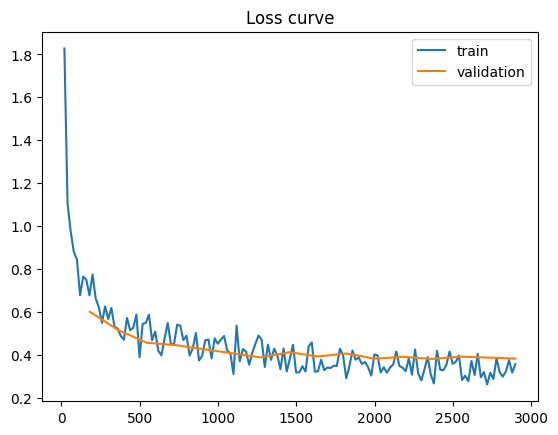

<Figure size 640x480 with 0 Axes>

In [23]:
# 1. Loss curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
plt.show()
plt.savefig(outdir/"loss.png")

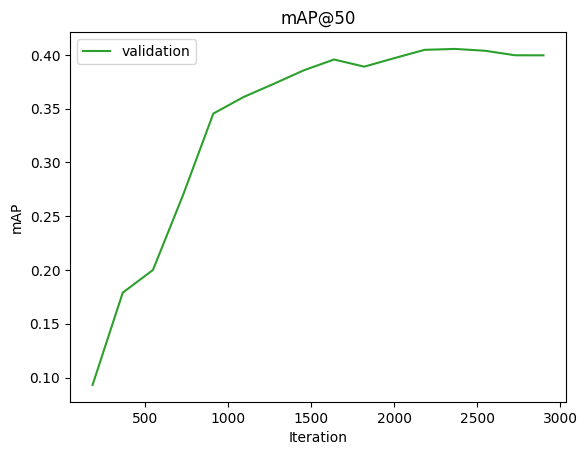

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()

mdf3 = mdf[~mdf["bbox/AP50"].isna()]

ax.plot(mdf3["iteration"], mdf3["bbox/AP50"] / 100., c="C2", label="validation")

ax.legend()
ax.set_title("mAP@50")
ax.set_xlabel("Iteration")
ax.set_ylabel("mAP")

plt.show()
plt.savefig(outdir / "mAP50.png")

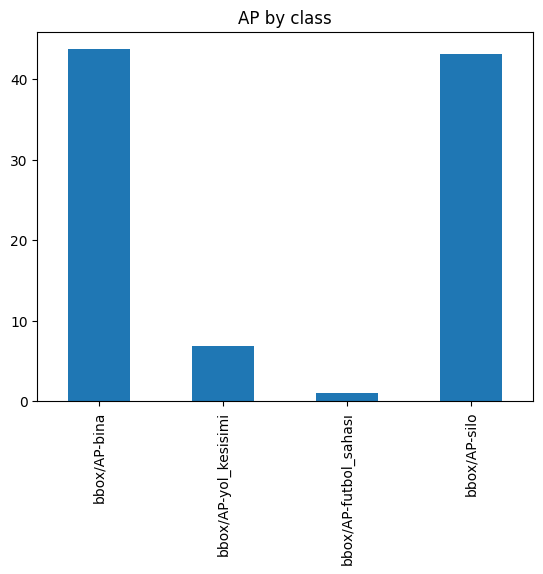

In [25]:
fig, ax = plt.subplots()
mdf_bbox_class = mdf3.iloc[-1][[f"bbox/AP-{col}" for col in thing_classes]]
mdf_bbox_class.plot(kind="bar", ax=ax)
_ = ax.set_title("AP by class")